In [29]:
setwd('C:/Users/iceca/Documents/Earthquake_Damage_Predictor/')
library(tidyverse)
library(ggplot2)
library(boot)
library(gridExtra)


In [30]:
loadNF <- modules::use('Helpers/Load_Num_Factor.R')
manipulate <- modules::use('Helpers/Manipulate.R')
numTrain <- loadNF$num()[[1]]
factorTrain <- loadNF$factor()[[1]]
labels <- loadNF$factor()[[2]] #num and factor features have the same labels
numTrain <- manipulate$combineLab(numTrain, labels)
factorTrain <- manipulate$combineLab(factorTrain, labels)

Joining, by = c("X", "building_id")
Joining, by = "X"


In [31]:
numTrain[1,]
factorTrain[1,]

X,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
1,802906,6,487,12198,2,30,6,5,1,...,0,0,0,0,0,0,0,0,0,3


X,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,building_id,damage_grade
1,t,r,n,f,q,t,d,v,802906,3


### Corrplots, to find the relationship between numerical features (treating label like numerical feature)


In [32]:
corNumTrain <- cor(numTrain)
cat('\n Features that show greatest corrrlation with each other \n \n')
for (i in 1:length(names(numTrain))) {
    for (j in 1:length(names(numTrain))) {
        
        if (abs(corNumTrain[i,j]) >0.3 && abs(corNumTrain[i,j]) <1.0 && i>=j) {
            cat(names(numTrain)[i] , names(numTrain)[j], corNumTrain[i,j], '\n')
        }
    }
}
labColNumber = 33
thr = 0.1
releventFeat <- sort( corNumTrain[,labColNumber][abs(corNumTrain[,labColNumber])>thr])
cat('\n Features that show greatest corrrlation with the label ')
names(releventFeat)
cat(releventFeat)


 Features that show greatest corrrlation with each other 
 
height_percentage count_floors_pre_eq 0.7715583 
has_superstructure_mud_mortar_stone has_superstructure_adobe_mud -0.3071836 
has_superstructure_mud_mortar_brick has_superstructure_adobe_mud 0.3172745 
has_superstructure_mud_mortar_brick has_superstructure_mud_mortar_stone -0.3758007 
has_superstructure_cement_mortar_brick has_superstructure_mud_mortar_stone -0.4712676 
has_superstructure_bamboo has_superstructure_timber 0.4395434 
has_secondary_use_agriculture has_secondary_use 0.7388177 
has_secondary_use_hotel has_secondary_use 0.5256072 

 Features that show greatest corrrlation with the label 

[1] "has_superstructure_cement_mortar_brick"
[2] "has_superstructure_rc_engineered"      
[3] "has_superstructure_rc_non_engineered"  
[4] "area_percentage"                       
[5] "count_floors_pre_eq"                   
[6] "has_superstructure_mud_mortar_stone"   
[7] "damage_grade"

-0.2543188 -0.1794018 -0.1580555 -0.1252037 0.1224673 0.2909351 1

#### Key findings between numerical features:
* Building height and are correlate very heavily
* has_superstructure_mud_mortar_brick , has_superstructure_mud_mortar_stone , has_superstructure_adobe_mud ; these 3 variables correlate very heavily
* A building that is used for agriculture or as a hotel has high chance of having a secondary use. Probably because these buildings have different seasonal uses. 

#### Key findings with regard to label:
* The more floors a home has the more likely it is to be damaged. This goes against the conventional belief that morefloors means greater flexibility/greater safety. 
* The more area a home has the safer it is
* Superstructure is a valuable variable, it shows that rc, mud mortar stone and cement mortar correlate heavily with label
* None of the features that had to do with building purpose/use were helpful in determing the label
* Having a cement mortar and mud mortar are significantly different, as such should be seperate variables

In [33]:
print( table(numTrain$has_superstructure_timber , numTrain$has_superstructure_bamboo)/(
    length(numTrain$has_superstructure_timber)+length(numTrain$has_superstructure_bamboo)) )

   
              0           1
  0 0.367568432 0.005011938
  1 0.089820500 0.037599130


It looks like a building is rarely just bamboo, hence bamboo does not provide significant information, remove it.

### Distribution of numerical buildings check

[1] "X"                                     
 [2] "building_id"                           
 [3] "geo_level_1_id"                        
 [4] "geo_level_2_id"                        
 [5] "geo_level_3_id"                        
 [6] "count_floors_pre_eq"                   
 [7] "age"                                   
 [8] "area_percentage"                       
 [9] "height_percentage"                     
[10] "has_superstructure_adobe_mud"          
[11] "has_superstructure_mud_mortar_stone"   
[12] "has_superstructure_stone_flag"         
[13] "has_superstructure_cement_mortar_stone"
[14] "has_superstructure_mud_mortar_brick"   
[15] "has_superstructure_cement_mortar_brick"
[16] "has_superstructure_timber"             
[17] "has_superstructure_bamboo"             
[18] "has_superstructure_rc_non_engineered"  
[19] "has_superstructure_rc_engineered"      
[20] "has_superstructure_other"              
[21] "count_families"                        
[22] "has_secondary_use"                     
[23] "has_secondary_use_agriculture"         
[24] "has_secondary_use_hotel"               
[25] "has_secondary_use_rental"              
[26] "has_secondary_use_institution"         
[27] "has_secondary_use_school"              
[28] "has_secondary_use_industry"            
[29] "has_secondary_use_health_post"         
[30] "has_secondary_use_gov_office"          
[31] "has_secondary_use_use_police"          
[32] "has_secondary_use_other"               
[33] "damage_grade"

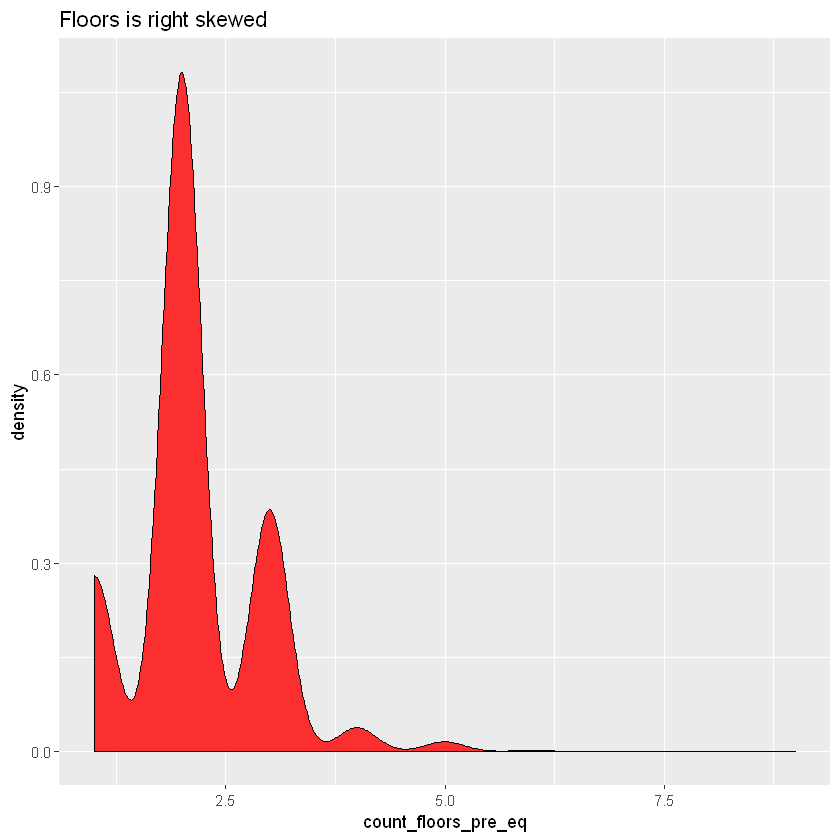

In [34]:
names(numTrain)

numTrain %>% ggplot(aes(count_floors_pre_eq)) +
    geom_density(fill = 'red',alpha=0.8,adjust=4) +
    ggtitle('Floors is right skewed')

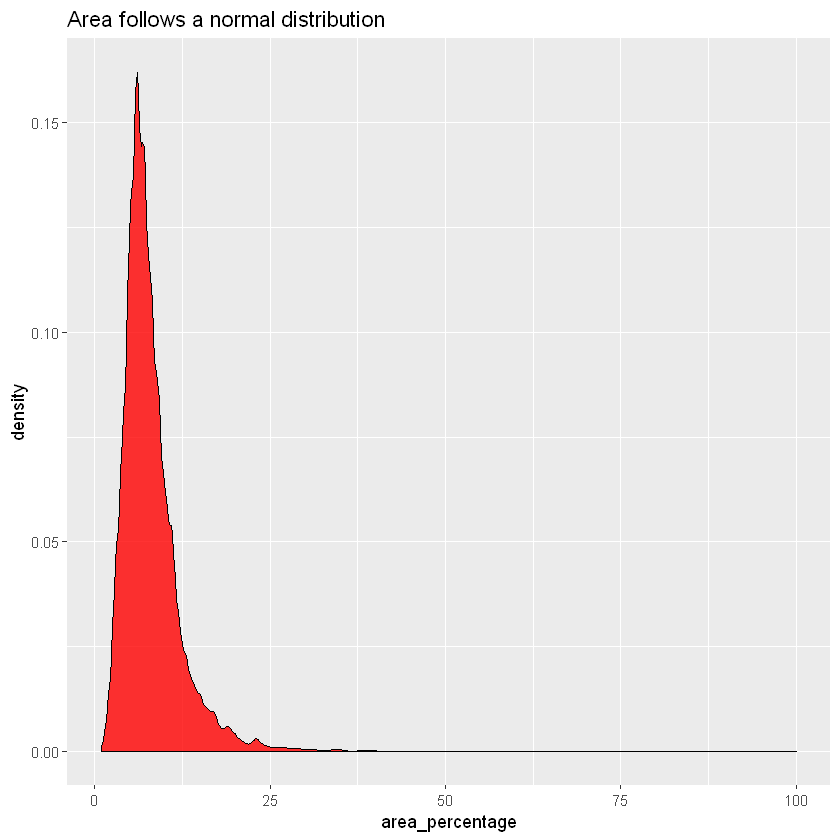

In [35]:
numTrain %>% ggplot(aes(area_percentage)) + geom_density(fill = 'red',alpha=0.8, adjust=2) +  ggtitle('Area follows a normal distribution')

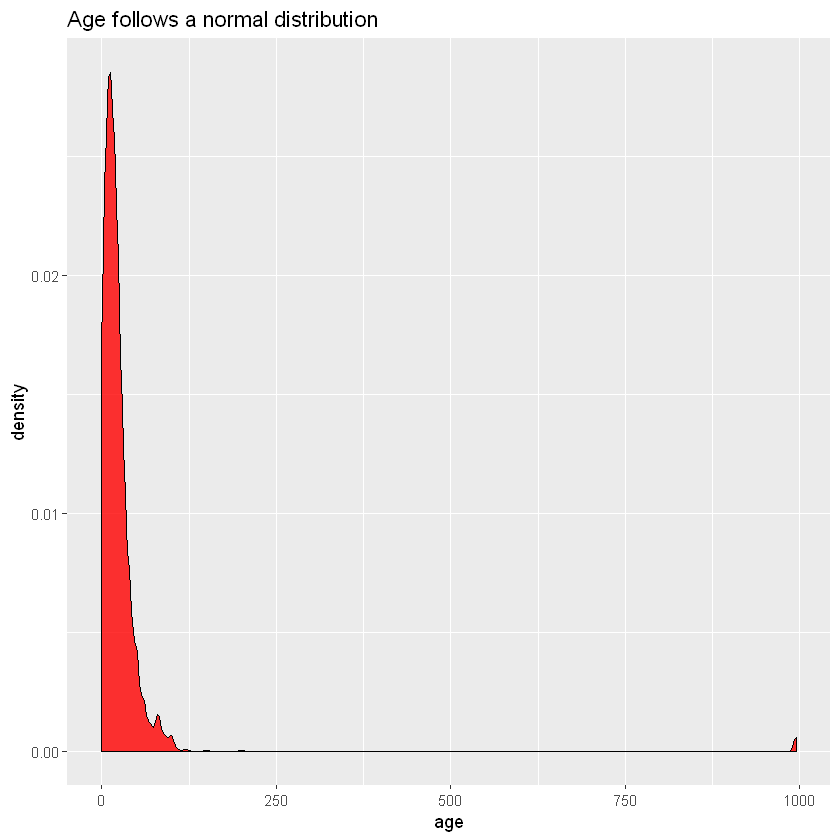

In [36]:
numTrain %>% ggplot(aes(age)) + geom_density(fill = 'red',alpha=0.8, adjust=3) +  ggtitle('Age follows a normal distribution')

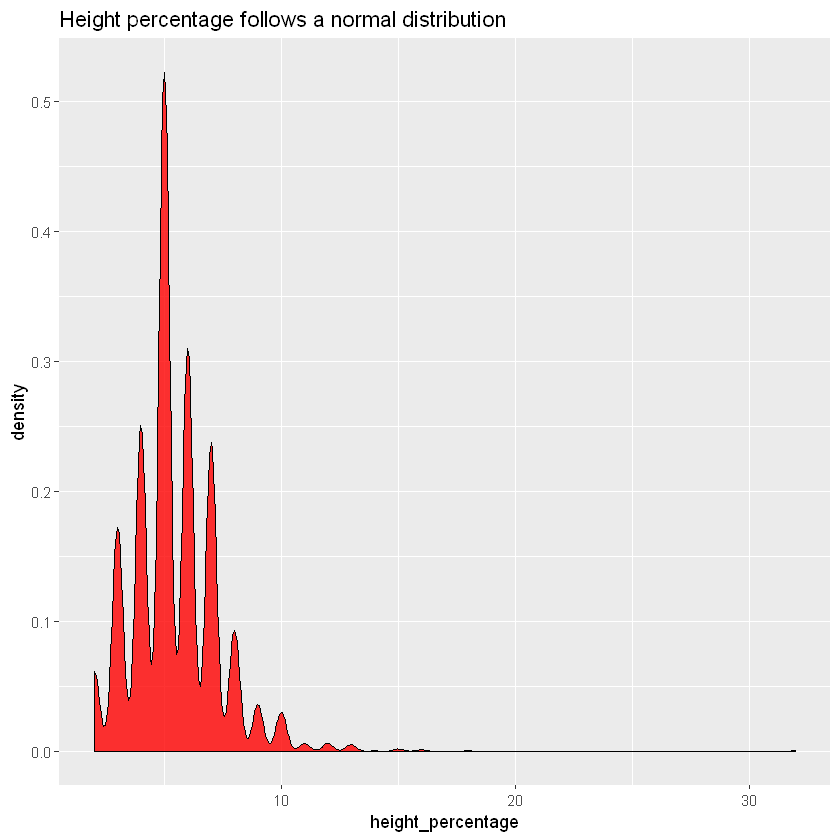

In [37]:
numTrain %>% ggplot(aes(height_percentage)) + geom_density(fill = 'red',alpha=0.8, adjust=2) +  ggtitle('Height percentage follows a normal distribution')

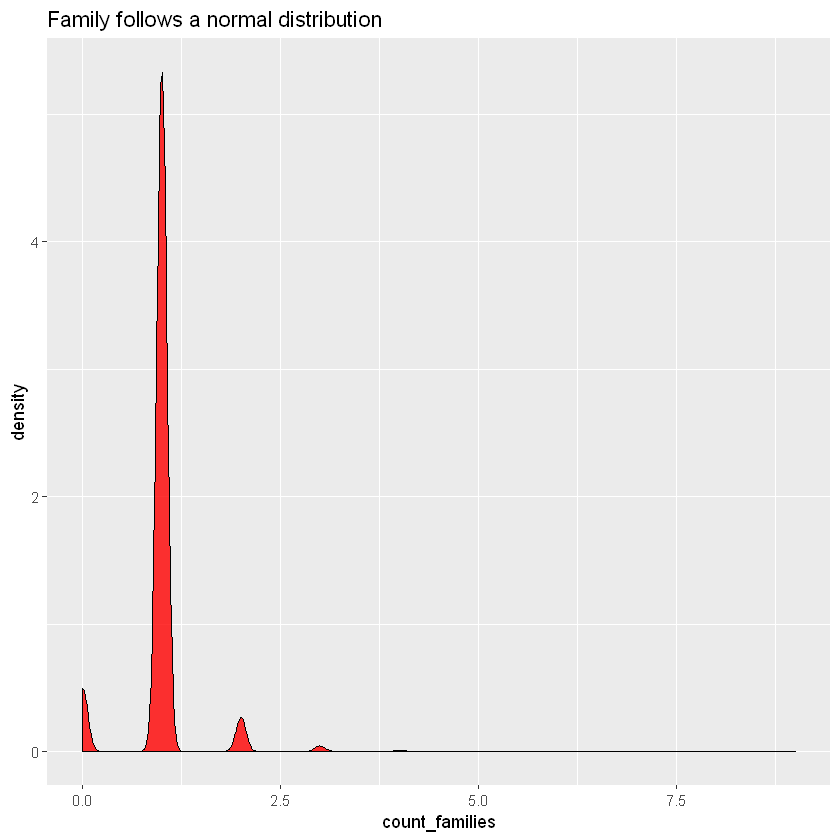

In [38]:
numTrain %>% ggplot(aes(count_families)) + geom_density(fill = 'red',alpha=0.8, adjust=2) +  ggtitle('Family follows a normal distribution')

### Analysing Binary Featurures

In [39]:
binaryFeat <- apply(numTrain,2,function(x) { all(x %in% 0:1) })
binTrain <- numTrain[,binaryFeat]
head(binTrain)
length(names(binTrain))

has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


[1] 22

In [40]:
cat('How many buildings have these features?')
apply(binTrain, 2, sum)#/nrow(binTrain)

How many buildings have these features?

has_superstructure_adobe_mud    has_superstructure_mud_mortar_stone 
                                 20842                                 178711 
         has_superstructure_stone_flag has_superstructure_cement_mortar_stone 
                                  8002                                   4311 
   has_superstructure_mud_mortar_brick has_superstructure_cement_mortar_brick 
                                 15999                                  17687 
             has_superstructure_timber              has_superstructure_bamboo 
                                 59770                                  19988 
  has_superstructure_rc_non_engineered       has_superstructure_rc_engineered 
                                  9976                                   3730 
              has_superstructure_other                      has_secondary_use 
                                  3530                                  26265 
         has_secondary_use_agriculture                has_secondary_use_hotel 
                                 15105                                   7896 
              has_secondary_use_rental          has_secondary_use_institution 
                                  1900                                    229 
              has_secondary_use_school             has_secondary_use_industry 
                                    89                                    254 
         has_secondary_use_health_post           has_secondary_use_gov_office 
                                    42                                     35 
          has_secondary_use_use_police                has_secondary_use_other 
                                    20                                   1202

In [41]:
#Investigating the interaction between binary features
x <- matrix(1:9, nrow = 3, dimnames = list(c("X","Y","Z"), c("A","B","C")))
nbin <- ncol(binTrain)
nameBin <- names(binTrain)
#interactionPval <- matrix(1:nbin^2, nrow=nbin, dimnames=list(nameBin,nameBin))
#interaction <- matrix(1:nbin^2, nrow=nbin, dimnames=list(nameBin,nameBin))
propInteraction <- matrix(1:nbin^2, nrow=nbin, dimnames=list(nameBin,nameBin))

for (i in 1:length(names(binTrain))) {
    for (j in 1:length(names(binTrain))) {
        freq <- prop.table(table(binTrain[,i], binTrain[,j]))
        propInteraction[i,j] = freq[2,2]/(freq[1,2]+freq[2,1])
        #interactionPval[i,j] =  summary(freq)$p.value
    }
}

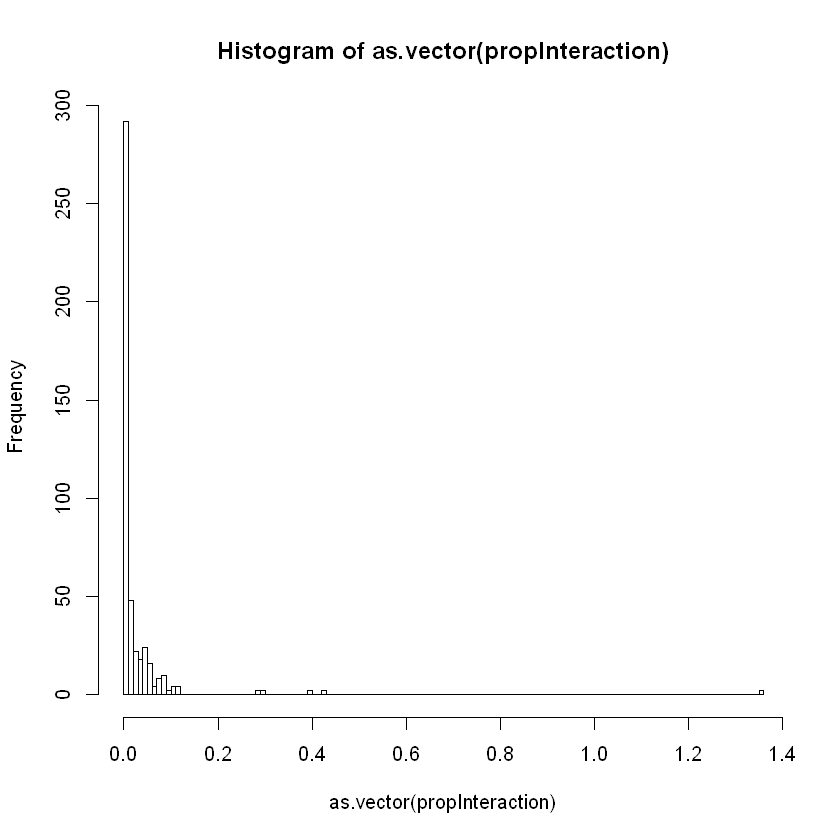

In [42]:
hist(as.vector(propInteraction), breaks=100)


Within the binary variables, they are fairly exclusive

In [43]:
#Investigating the relationship between binary variables and the label
x <- matrix(1:9, nrow = 3, dimnames = list(c("X","Y","Z"), c("A","B","C")))
interactionPval <- 1:nbin

names(interactionPval) <- nameBin
for (i in 1:length(names(binTrain))) {
    freq <- table(binTrain[,i], numTrain$damage_grade)
    cat('Table for variable ', nameBin[i])
    print(prop.table(freq))    
    cat('\n')
    interactionPval[i] =  summary(freq)$p.value
}
interactionPval

Table for variable  has_superstructure_adobe_mud   
              1           2           3
  0 0.093941332 0.515660442 0.301534919
  1 0.002276797 0.053538842 0.033047668

Table for variable  has_superstructure_mud_mortar_stone   
             1          2          3
  0 0.06268440 0.13170035 0.04365140
  1 0.03353373 0.43749893 0.29093118

Table for variable  has_superstructure_stone_flag   
               1            2            3
  0 0.0955359427 0.5519015946 0.3184446150
  1 0.0006821864 0.0172976891 0.0161379722

Table for variable  has_superstructure_cement_mortar_stone   
              1           2           3
  0 0.092994798 0.556612944 0.332011597
  1 0.003223331 0.012586339 0.002570990

Table for variable  has_superstructure_mud_mortar_brick   
              1           2           3
  0 0.093868850 0.524298627 0.313618146
  1 0.002349279 0.044900657 0.020964441

Table for variable  has_superstructure_cement_mortar_brick   
              1           2           3
  0 0.06

has_superstructure_adobe_mud    has_superstructure_mud_mortar_stone 
                         2.367378e-288                           0.000000e+00 
         has_superstructure_stone_flag has_superstructure_cement_mortar_stone 
                         1.307480e-224                          3.030746e-193 
   has_superstructure_mud_mortar_brick has_superstructure_cement_mortar_brick 
                         8.155076e-209                           0.000000e+00 
             has_superstructure_timber              has_superstructure_bamboo 
                         4.576990e-263                          2.049334e-213 
  has_superstructure_rc_non_engineered       has_superstructure_rc_engineered 
                          0.000000e+00                           0.000000e+00 
              has_superstructure_other                      has_secondary_use 
                          7.390718e-55                           0.000000e+00 
         has_secondary_use_agriculture                has_secondary_use_hotel 
                         9.261041e-116                           0.000000e+00 
              has_secondary_use_rental          has_secondary_use_institution 
                          0.000000e+00                           2.802133e-59 
              has_secondary_use_school             has_secondary_use_industry 
                          9.176732e-13                           2.324871e-11 
         has_secondary_use_health_post           has_secondary_use_gov_office 
                          1.233395e-04                           7.474952e-08 
          has_secondary_use_use_police                has_secondary_use_other 
                          7.097320e-01                           2.989791e-16

A lot of the binary variables have a low pvalue compared with the label, so according to the pvalue atleast they are goot predictors. However, when looking closer at the tables, these results are because most buildings are of damage_grade 2, making the tables look like asthough they are doing a good job of predicting. 

In [55]:
binTrain %>% 
    mutate(damage_grade =labels$damage_grade) ->
    binTrain2
nameBin2 <- names(binTrain2)
numFeat <- length(nameBin2)
plots <- list()
plotBinLab <- function(start,end, nameBin2, binTrain2, plots) {
    for (i in start:end) {
        print(i)
        hasFeature = binTrain2[,nameBin2[i]] == 1
        p <- binTrain2[hasFeature,] %>% ggplot(aes(damage_grade,fill=damage_grade))
        p <- p + geom_bar(aes(y= (..count..)/sum(..count..)))
        #p <- p + facet_grid(rows = nameBin2[i]) 
        p <- p + ggtitle(paste('Comparison of damage grade among ',nameBin2[i]))
        plots[[i]] <- p
    }
    print('done')
    plots[[1]]
    n <- length(plots)
    nCol <- floor(sqrt(n))
    do.call("grid.arrange", c(plots, ncol=nCol))
}


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] "done"


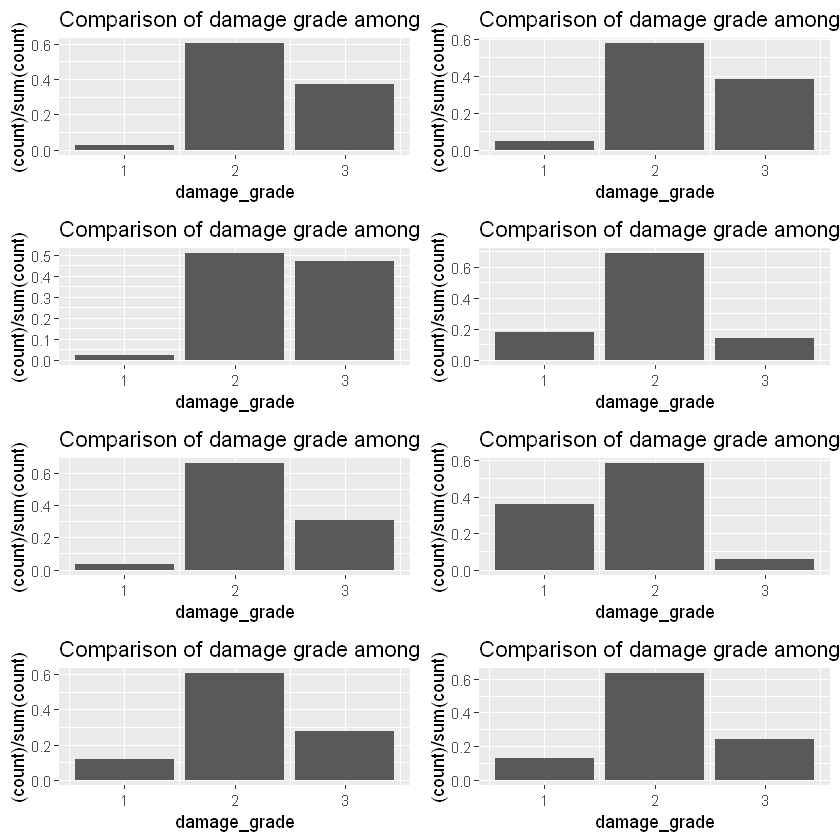

In [56]:
plotBinLab(1,8, nameBin2, binTrain2, plots)

#plotBinLab(1,8, nameBin2, binTrain2)
#plotBinLab(9,16, nameBin2, binTrain2)
#plotBinLab(17,22, nameBin2, binTrain2)

   
             1          2          3
  0 0.09891056 0.57139641 0.32969303
  1 0.01999500 0.50699825 0.47300675

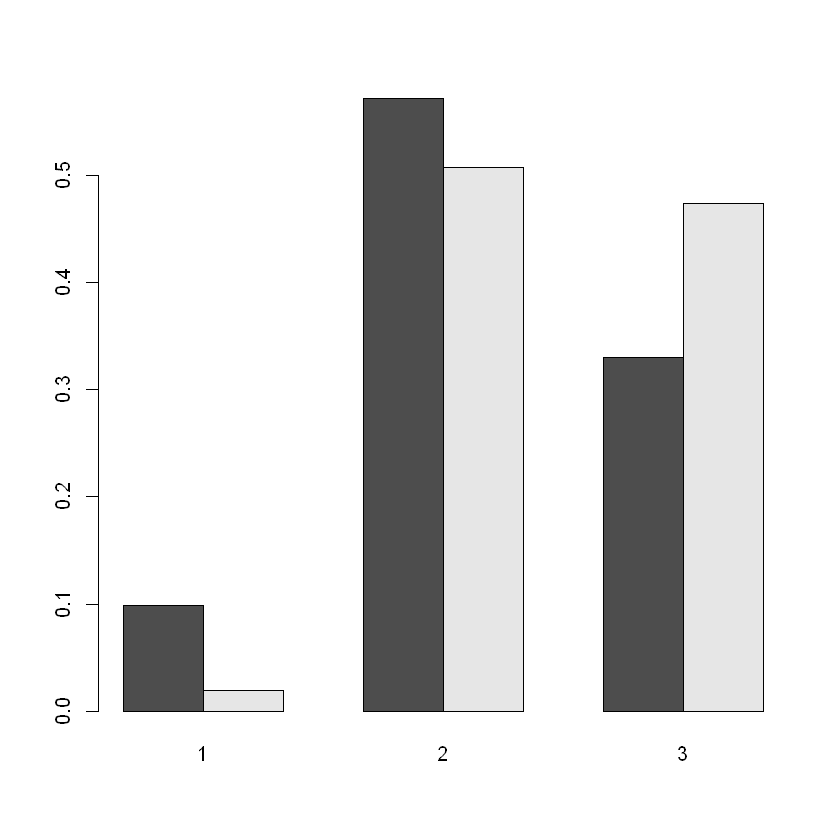

In [67]:
a <- prop.table(table(binTrain2$has_superstructure_stone_flag, numTrain$damage_grade), 1)
a
barplot( a , beside=TRUE)
#barplot(prop.table(table(numTrain$damage_grade)), xlab='damage grade')